In [1]:
from collections import OrderedDict
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
plt.style.use('dark_background')

In [2]:
from get_observed import get_samples
from heston import infer_heston_parameters, Heston

In [3]:
STOCK_NAME = "MSFT"
START = datetime(2015, 1, 1)
END = datetime(2024, 1, 1)
PREDICITON_PERIOD = 60
NUM_SAMPLES = 1000
NUM_SIMULATIONS = 64
NUM_PLOTS = 20
DT = 1
INTERVAL = "1d"
LOCAL_WINDOW_SIZE = 5

In [4]:
trajectories = get_samples(STOCK_NAME, START, END, PREDICITON_PERIOD, interval=INTERVAL, local_window_size=LOCAL_WINDOW_SIZE, sample_size=NUM_SAMPLES)

[*********************100%***********************]  1 of 1 completed


In [5]:
all_parameters = {}
actual_and_predictions = []

for trajectory in trajectories:
    parameters = infer_heston_parameters(trajectory)
    heston = Heston(**parameters)
    predictions = heston.predict(trajectory, num_simulations=NUM_SIMULATIONS, dt=DT)

    actual_and_predictions.append((trajectory, predictions))
    all_parameters[trajectory.index[0].date()]  = parameters

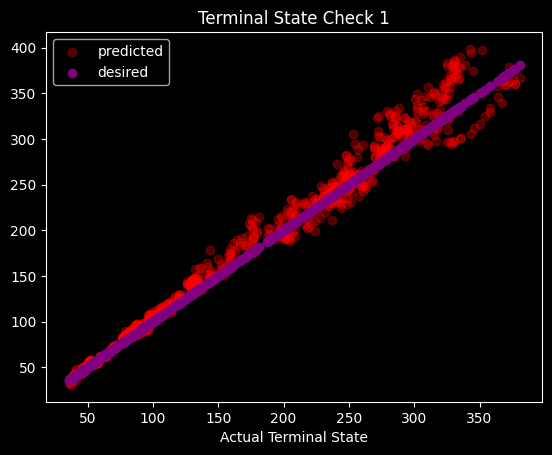

In [6]:
# Terminal State Check

actual_terminals, predicted_terminals = OrderedDict(), OrderedDict()

for actual, predictions in actual_and_predictions:
    actual_terminal_state = actual.iloc[-1]["S"]
    predicted_terminal_states = predictions[-1, ..., 0]
    actual_terminals[actual.index[0].date()] = actual_terminal_state
    predicted_terminals[actual.index[0].date()] = predicted_terminal_states.numpy().mean()

plt.scatter(actual_terminals.values(), predicted_terminals.values(), label="predicted", color="red", alpha=.3)
plt.scatter(actual_terminals.values(), actual_terminals.values(), label="desired", color="purple")
plt.xlabel("Actual Terminal State")
plt.legend()
plt.title("Terminal State Check 1")
plt.show()

px.scatter(
    pd.DataFrame({"actual terminal states": actual_terminals, "mean predicted terminal states": predicted_terminals}),
    template="plotly_dark",
    title="Terminal State Check 2"
)


$$ \operatorname{d}S_t = rS_t\operatorname{d}t + \sqrt{\nu_t}S_t\operatorname{d}W^1_t $$
$$ \operatorname{d}\nu_t = \eta(\theta-\nu_t)\operatorname{d}t + \xi\sqrt{\nu_t}\operatorname{d}W^2_t $$

$$ S_{t_{n+1}}-S_{t_n} = rS_{t_n}(t_{n+1}-t_n) + \sqrt{\nu_{t_n}}S_{t_n}\sqrt{(t_{n+1}-t_n)}\mathcal{N}(0, 1) $$
$$ \nu_{t_{n+1}}-\nu_{t_n} = \eta(\theta-\nu_{t_n})(t_{n+1}-t_n) + \xi\sqrt{\nu_{t_n}}\sqrt{(t_{n+1}-t_n)}\mathcal{N}(0, 1) $$

$$ \mathbb{E}\left[\frac{S_{t_{n+1}}-S_{t_n}}{S_{t_n}(t_{n+1}-t_n)}\right] = r $$
$$ \mathbb{E}\left[\frac{\nu_{t_{n+1}}-\nu_{t_n}}{(\theta-\nu_{t_n})(t_{n+1}-t_n)}\right] = \eta $$
$$ \operatorname{std}\left[\frac{\nu_{t_{n+1}}-\nu_{t_n}-\eta(\theta-\nu_{t_n})(t_{n+1}-t_n)}{\sqrt{\nu_{t_n}(t_{n+1}-t_n)}}\right] = \xi $$
$$ \operatorname{var}\left[\frac{S_{t_{n+1}}-S_{t_n}-rS_{t_n}(t_{n+1}-t_n)}{S_{t_n}\sqrt{t_{n+1}-t_n}}\right] = \nu_{t_n}$$

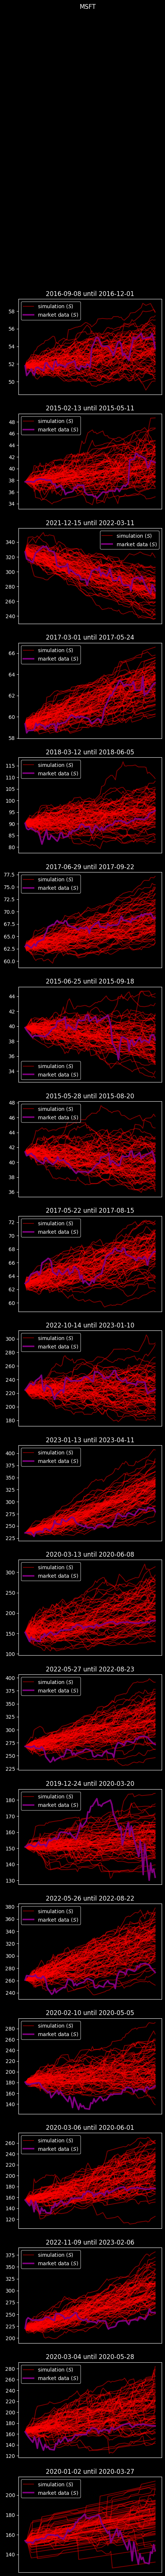

In [7]:
actual_terminals, predicted_terminals = map(lambda a: np.array(list(a)), [actual_terminals.values(), predicted_terminals.values()])
diffs = np.abs((actual_terminals - predicted_terminals) / actual_terminals)
best = np.argsort(diffs)[: NUM_PLOTS // 2]
worst = np.argsort(diffs)[- NUM_PLOTS // 2 :]

fig, axs = plt.subplots(NUM_PLOTS, 1)
fig.set_size_inches(5, 4 * NUM_PLOTS)

for i, index in enumerate(np.concat([best, worst])):
    actual, predictions = actual_and_predictions[index]
    for j, prediction in enumerate(predictions[..., 0].transpose(0, 1)):
        axs[i].plot(actual.index, prediction.detach(), c="red", alpha=.5, label="simulation ($S$)" if j == 0 else None)
    axs[i].plot(actual.index, list(actual["S"]), c="purple", linewidth=3, label="market data ($S$)")
    axs[i].set_title(f"{actual.index[0].date()} until {actual.index[-1].date()}")
    axs[i].legend()
    axs[i].set_xticks([])

plt.show()

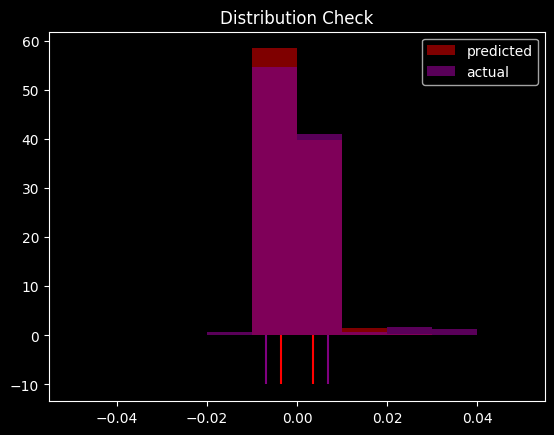

In [8]:
# VARIANCE CHECK

actual_distribution, predicted_distribution = [], []

for actual, predictions in actual_and_predictions:
    actual, predictions = np.array(actual["S"]), predictions[..., 0]
    actual_quotients, predicted_quotients = actual[1:] / actual[:-1], predictions[1:] / predictions[:-1]
    actual_stationary_quotients, predicted_stationary_quotients = actual_quotients - actual_quotients.mean(), predicted_quotients - predicted_quotients.mean(axis=0)
    actual_distribution.append(actual_stationary_quotients.std())
    predicted_distribution.extend(predicted_stationary_quotients.std(axis=0))

actual_distribution, predicted_distribution = map(np.array, [actual_distribution, predicted_distribution])
actual_distribution, predicted_distribution = actual_distribution - actual_distribution.mean(), predicted_distribution - predicted_distribution.mean()

plt.hist(predicted_distribution, range=(-.05, .05), histtype="stepfilled", density=True, color="red", alpha=.5, label="predicted")
plt.vlines([- predicted_distribution.std(), predicted_distribution.std()], ymin=-10, ymax=0, color="red")
plt.hist(actual_distribution, range=(-.05, .05), histtype="stepfilled", density=True, color="purple", alpha=.7, label="actual")
plt.vlines([- actual_distribution.std(), actual_distribution.std()], ymin=-10, ymax=0, color="purple")
plt.title("Distribution Check")
plt.legend()
plt.show()

In [9]:
all_parameters = pd.DataFrame.from_dict(all_parameters, orient="index").sort_index()
all_parameters = (all_parameters - all_parameters.mean()) / all_parameters.std()
px.line(all_parameters)